# Double Derived Markov chain w/ contexts



In [1]:
def extract_first_cycle(sequence,cycle_shift=True):
    seen = {}
    start = None
    end = None

    for i, item in enumerate(sequence):
        if item in seen:
            if start is None:
                start = seen[item]
                end = i
            else:
                break
        else:
            seen[item] = i

    if start is not None and end is not None:
        if cycle_shift:
            return cyclic_shift(sequence[start:end+1]), sequence[0:start]+sequence[end:]
        else:
            return sequence[start:end+1], sequence[0:start]+sequence[end:]
    else:
        return None, sequence[end:]

In [2]:
def derived_graph(G,r=None,edge_labels='both'):
    if r==None:
        r=G.vertices(sort=True)[0]
    def doit(DerG):
        sink_list = DerG.sinks()
        if len(sink_list)==0:
            return DerG
        else:
            for w in sink_list:
                for u in G.neighbor_out_iterator(w[-1]):
                    cyc, seq = extract_first_cycle(w+(u,),cycle_shift=False)
                    if cyc==None:
                        cyc=()
                    if edge_labels=='cyc':
                        DerG.add_edge(w,seq,cyc)
                    elif edge_labels=='rate':
                        DerG.add_edge(w,seq,G.edge_label(w[-1],seq[-1]))
                    elif edge_labels=='both':
                        DerG.add_edge(w,seq,(G.edge_label(w[-1],seq[-1]),cyc))
        return doit(DerG)
    DerG = DiGraph()
    DerG.add_vertex((r,))
    return doit(DerG)

In [3]:
def cartesian_edge_color(GH,verbose=True):
    # Define edge colors
    R = rainbow(2)
    edge_colors = {}
    for i in range(2):
        edge_colors[R[i]] = []

    # Apply edge colors
    for edge in GH.edges():
        u, v, label = edge
        if u[0] == v[0]:
            edge_colors[R[0]].append(edge)
        if u[1] == v[1]:
            edge_colors[R[1]].append(edge)

    # Plot the Cartesian product with edge colors
    if verbose:
        GH.show(edge_colors=edge_colors)
        #GH.graphplot(vertex_labels=False, vertex_size=0,edge_colors=edge_colors).show()
    return edge_colors

In [4]:
def double_derived_graph_with_context(DerG,DerH,verbose=False):
    Vg = edge_ring_from_derived_graph(DerG)
    Vh = edge_ring_from_derived_graph(DerH)
    groot = DerG.vertices(sort=True)[0][0] # first element of tuple vertex = (0,) ==> groot = 0
    hroot = DerH.vertices(sort=True)[0][0]
    gh_vars = [];
    for g_var in Vg.gens():
        gh_vars += [str(g_var)+'%s'%(i+hroot) for i in range(H.order()) ]
    for h_var in Vh.gens():
        gh_vars += [str(h_var)+'%s'%(i+groot) for i in range(G.order()) ]
    gh_vars = list(set(gh_vars))
    Vgh = PolynomialRing(ZZ, names=gh_vars)
    DDerGH = DerG.cartesian_product(DerH)
    for edge in DDerGH.edges():
        DDerGH.set_edge_label(edge[0],edge[1],None)
        if edge[0][0]==edge[1][0]:
            hfr = edge[0][1]
            hto = edge[1][1]
            if verbose:
                print('h changed:',edge,':',hfr,'->',hto)
            gh_var = Vgh( str(DerH.edge_label(hfr,hto)[0] ) + str( hfr[-1] ))
            new_label = (gh_var,DerH.edge_label(hfr,hto)[1])
            DDerGH.set_edge_label(edge[0],edge[1],new_label)
        if edge[0][1]==edge[1][1]:
            gfr = edge[0][0]
            gto = edge[1][0]
            if verbose:
                print('g changed:',edge,':',gfr,'->',gto)
            gh_var = Vgh( str(DerH.edge_label(gfr,gto)[0] ) + str( gfr[-1] ))
            new_label = ( gh_var, DerG.edge_label(gfr,gto)[1])
            DDerGH.set_edge_label(edge[0],edge[1],new_label)
    return DDerGH

In [5]:
def double_derived_graph_without_context(DerG,DerH,verbose=False):
    DDerGH = DerG.cartesian_product(DerH)
    Vg = edge_ring_from_derived_graph(DerG)
    Vh = edge_ring_from_derived_graph(DerH)
    Vgh = merge_edge_rings(Vg,Vh)
    for edge in DDerGH.edges():
        DDerGH.set_edge_label(edge[0],edge[1],None)
        if edge[0][0]==edge[1][0]:
            hfr = edge[0][1]
            hto = edge[1][1]
            if verbose:
                print('h changed:',edge,':',hfr,'->',hto)
            new_label = (Vgh(DerH.edge_label(hfr,hto)[0]),DerH.edge_label(hfr,hto)[1])
            DDerGH.set_edge_label(edge[0],edge[1],new_label)
        if edge[0][1]==edge[1][1]:
            gfr = edge[0][0]
            gto = edge[1][0]
            if verbose:
                print('g changed:',edge,':',gfr,'->',gto)
            new_label = ( Vgh(DerG.edge_label(gfr,gto)[0]), DerG.edge_label(gfr,gto)[1])
            DDerGH.set_edge_label(edge[0],edge[1],new_label)
    return DDerGH

In [6]:
def double_derived_graph(DerG,DerH,context=False,reduce=False,verbose=False):
    if context:
        DDerGH = double_derived_graph_with_context(DerG,DerH,verbose=verbose)
    else:
        DDerGH = double_derived_graph_without_context(DerG,DerH,verbose=verbose)
    if reduce:
        if DerG == DerH:
            DDerGH = symmetrize(DDerGH,rates=True)
        else:
            print('Warning: Cannot reduce when DerG not equal to DerH')
    return DDerGH

In [7]:
def merge_edge_rings(Vg,Vh):
    gh_vars = [ str(g_var) for g_var in Vg.gens() ] + [ str(h_var) for h_var in Vh.gens() ]
    gh_vars = list(set(gh_vars))
    return PolynomialRing(ZZ, names=gh_vars)

In [8]:
def Cartesian_product_without_context(G, H):
    GH = G.cartesian_product(H)
    Vg = edge_ring_from_graph(G)
    Vh = edge_ring_from_graph(H)
    Vgh = merge_edge_rings(Vg,Vh)
    for v in GH.vertices(sort=True):
        for u in GH.vertices(sort=True):
            if v!=u:
                if v[0]==u[0] and H.has_edge(v[1],u[1]):
                    GH.set_edge_label(v,u,Vgh(H.edge_label(v[1],u[1])))
                if v[0]==u[0] and H.has_edge(u[1],v[1]):
                    GH.set_edge_label(u,v,Vgh(H.edge_label(u[1],v[1])))
                if v[1]==u[1] and G.has_edge(v[0],u[0]):
                    GH.set_edge_label(v,u,Vgh(G.edge_label(v[0],u[0])))
                if v[1]==u[1] and G.has_edge(u[0],v[0]):
                    GH.set_edge_label(u,v,Vgh(G.edge_label(u[0],v[0])))
    return GH

In [9]:
def Cartesian_product_with_context(G, H):
    Vg = edge_ring_from_graph(G)
    Vh = edge_ring_from_graph(H)
    groot = G.vertices(sort=True)[0]
    hroot = H.vertices(sort=True)[0]
    gh_vars = [];
    for g_var in Vg.gens():
        gh_vars += [str(g_var)+'%s'%(i+hroot) for i in range(H.order()) ]
    for h_var in Vh.gens():
        gh_vars += [str(h_var)+'%s'%(i+groot) for i in range(G.order()) ]
    gh_vars = list(set(gh_vars))
    Vgh = PolynomialRing(ZZ, names=gh_vars)
    GH = G.cartesian_product(H)
    for v in GH.vertices(sort=True):
        for u in GH.vertices(sort=True):
            if v!=u:
                if v[0]==u[0] and H.has_edge(v[1],u[1]):
                    gh_var = Vgh(str(H.edge_label(v[1],u[1])) + str(v[0]))
                    GH.set_edge_label(v,u,gh_var)
                if v[0]==u[0] and H.has_edge(u[1],v[1]):
                    gh_var = Vgh(str(H.edge_label(u[1],v[1])) + str(v[0]))
                    GH.set_edge_label(u,v,gh_var)
                if v[1]==u[1] and G.has_edge(v[0],u[0]):
                    gh_var = Vgh(str(G.edge_label(v[0],u[0])) + str(v[1]))
                    GH.set_edge_label(v,u,gh_var)
                if v[1]==u[1] and G.has_edge(u[0],v[0]):
                    gh_var = Vgh(str(G.edge_label(u[0],v[0])) + str(v[1]))
                    GH.set_edge_label(u,v,gh_var)
    return GH

In [10]:
def Cartesian_product(G, H, context=False):
    if context:
        GH = Cartesian_product_with_context(G, H)
    else:
        GH = Cartesian_product_without_context(G, H)
    return GH

In [11]:
def edge_ring_from_graph(G):
    Vg = G.random_edge()[2].parent()
    return Vg

In [12]:
def edge_ring_from_derived_graph(DerG):
    Vg = DerG.random_edge()[2][0].parent()
    return Vg

In [13]:
def weighted_laplacian_matrix(G):
    verts = G.vertices(sort=True)
    A = G.weighted_adjacency_matrix(verts)
    Q = A - diagonal_matrix(sum(A.T))
    return Q

In [14]:
def my_trees(Q,vdel=None,vdict=None,verbose=False,big=False): # Note: vdel needs to be a list, such as [0] or [0,3,4], or None 
    if vdel!=None:
        if isinstance(vdel, tuple):
            vdel = list(vdel)
        if isinstance(vdel, list) == False:
            raise ValueError("vdel must be a list of vertices or integers")
        if vdict==None:
            vd = vdel
        else:
            vd = [ vdict[key] for key in vdel ]
        if big==False:
            Q0 = Q.delete_rows(vd).delete_columns(vd)
            t = det(Q0)*(-1)^Q0.nrows()
        else: 
            G = DiGraph(Q)
            G.merge_vertices(vd)
            r = vd[0] 
            # Note: The next line is r=vd[0] because merge_vertices results
            # in the new vertex is named after the first vertex in the merge list
            # https://doc.sagemath.org/html/en/reference/graphs
            # /sage/graphs/generic_graph.html#sage.graphs.generic_graph.GenericGraph.merge_vertices
            G.remove_loops()
            VV = Q[0,0].parent() # the ring of edge labels 
            t = VV(0)
            for k,in_branching in enumerate(G.in_branchings(r)):
                edge_str = ''
                edge_prod = VV(1)
                for e in in_branching.edges():
                    edge_str += str(e[2])
                    edge_prod *= e[2]
                t += edge_prod
                if verbose:
                    in_branching.show(figsize=4,graph_border=True,\
                                      edge_labels=True,title=str(k)+': '+edge_str)
        if verbose:
            print('For root/cycle',vdel,':',t.factor(),'\n')
        return t
    else:
        T = []
        if vdict==None:
            for i in range(Q.ncols()):
                t = my_trees(Q,vdel=[i],verbose=verbose,big=big)
                T.append(t)
        else:
            for key in vdict.keys():
                t = my_trees(Q,vdel=[key],vdict=vdict,verbose=verbose,big=big)
                T.append(t)
        return T

In [15]:
def cycle_flux_analysis(G,verbose=True,str=''):
    if verbose:
        print()
        G.show(title=str,edge_labels=True,graph_border=True,figsize=5)
    nvG = G.order(); neG = G.size(); betaG = neG-nvG+1;
    vG = [ v for v in G.vertices(sort=True) ]
    dict_vG = dict(zip(vG,range(nvG))); 
    inverted_dict_vG = {value: key for key, value in dict_vG.items()}
    Q_G = weighted_laplacian_matrix(G)
    if verbose:
        print()
        print(Q_G)
        print()
    Tg = my_trees(Q_G,verbose=verbose)
    TG = sum(Tg)
    cycleG_p, cycleG_m, cycleG_2 = simple_cycles(G,minsize=2)
    cycleG = cycleG_p + cycleG_m + cycleG_2
    if verbose:
        print(str,'cycles p:',cycleG_p,'\n')
        print(str,'cycles m:',cycleG_m,'\n')
        print(str,'cycles 2:',cycleG_2,'\n')
        print()
    d_cycleG = { k:v for k,v in enumerate(cycleG) }
    inverted_d_cycleG = {value: key for key, value in d_cycleG.items()}
    Jg = []
    for i,cyc in enumerate(cycleG):
        Pi = make_pi_one_way(G,cyc)
        Jg.append(Pi*my_trees(Q_G,cyc,vdict=dict_vG,verbose=False))
        if verbose:
            print(str,'cycle flux',i,':',Jg[i].factor())
            print()
    return nvG, neG, betaG, Tg, TG, cycleG_p, cycleG_m, cycleG_2, cycleG, Jg, dict_vG, inverted_dict_vG, d_cycleG, inverted_d_cycleG

In [16]:
def simple_cycles(D,minsize=2,maxsize=1000):
    # Note: this uses cyclic_shift() function
    cycles_p0=[]
    for c in D.all_simple_cycles():
        if len(c)>max(minsize,3) and len(c)<=maxsize and list(reversed(c)) not in cycles_p0:
            cycles_p0.append(c)
    cycles_p=[]
    for c in cycles_p0:
        cycles_p.append(cyclic_shift(c))
    #
    cycles_m=[]
    for c in cycles_p:
        cycles_m.append(list(reversed(c)))
        # next line: this makes cp<cm for each pair
        # (cycle called positive is lexicographically smaller)
    for i in range(len(cycles_p)):
        cp = cycles_p[i]
        cm = cycles_m[i]
        if cp>cm: # want cp<cm
            cycles_p[i]=cm
            cycles_m[i]=cp
    cycles_p = [ tuple(c) for c in cycles_p]
    cycles_m = [ tuple(c) for c in cycles_m]

    # two-cycles
    if minsize==2:
        cycles_2_0=[]
        for c in D.all_simple_cycles():
            if len(c)==3 and list(reversed(c)) not in cycles_p0:
                cycles_2_0.append(c)
        cycles_2=[]
        for c in cycles_2_0:
            cycles_2.append(cyclic_shift(c))
        cycles_2 = [ tuple(c) for c in cycles_2]
        return cycles_p, cycles_m, cycles_2
    else:
        return cycles_p, cycles_m

In [17]:
def cyclic_shift(c,shift='default'): # 'default' shifts so that first element is minimal, presumes a simple cycle
    if c[-1]==c[0]:
        if shift=='default':
            c = c+c[1:]
            i = c.index(min(c))
            j = c.index(min(c),i+1) # i+1 is the starting index from which to search for min(c)
            return c[i:j+1]
        else:
            n=len(c)
            c = c+c[1:]
            return c[shift:shift+n]
    else:
        raise ValueError(str(c)+" is not a cycle.")

In [18]:
def make_pi_one_way(D,cyc):
    p = 1;
    for i in range(len(cyc)-1):
        p=p*D.edge_label(cyc[i],cyc[i+1])
    return p

In [19]:
def split_derived_graph(DerG):
    DerGrate = copy(DerG)
    DerGcyc = copy(DerG)
    for e in DerGrate.edges(sort=True):
        DerGrate.set_edge_label(e[0],e[1], DerG.edge_label(e[0],e[1])[0])
    for e in DerGcyc.edges(sort=True):
        DerGcyc.set_edge_label(e[0],e[1],DerG.edge_label(e[0],e[1])[1])
    return DerGrate, DerGcyc

In [20]:
def cycle_fluxes_from_derived_graph(DerG,verbose=False,big=False,factor=True):
    DerGrate, DerGcyc = split_derived_graph(DerG)
    vDerG = [ v for v in DerGcyc.vertices(sort=True) ]
    dict_vDerG = dict(zip(vDerG,range(len(vDerG))))
    Q_DerG = weighted_laplacian_matrix(DerGrate)
    T = my_trees(Q_DerG,vdel=None,vdict=None,verbose=False,big=big)
    if verbose:
        print('rooted spanning tree of derived graph T(0,0) =',sum(T).factor(),'\n')
    Jg = []
    dict_Jg_lumped = {}
    for e in DerGcyc.edges(sort=True):
        if DerGcyc.edge_label(e[0],e[1]):
            X = T[dict_vDerG[e[0]]]*DerGrate.edge_label(e[0],e[1]) # Note: do not factor X (if you do, you can't +=X below)
            if factor:
                Jg.append(X.factor())
            else:
                Jg.append(X)
            if verbose:
                print('J',e[2],'=', Jg[-1],'\n')
            cyc = cyclic_shift(DerGcyc.edge_label(e[0],e[1]))
            if cyc in dict_Jg_lumped:
                dict_Jg_lumped[cyc] += X
            else:
                dict_Jg_lumped[cyc] = X
    if factor:
        for key in dict_Jg_lumped:
            dict_Jg_lumped[key] = dict_Jg_lumped[key].factor()
    return dict_Jg_lumped

In [21]:
def graph_and_edge_ring_from_dict(dG):
    Gstr = DiGraph(dG)
    g_vars = [ e[2] for e in Gstr.edges(sort=True) ]
    Vg=PolynomialRing(ZZ,names=g_vars,order='invlex')
    G = copy(Gstr)
    for estr in Gstr.edges(sort=True):
        G.set_edge_label(estr[0],estr[1],Vg(estr[2]))
    return G, Vg

In [22]:
def symmetrize(DerGH,rates=False):
    DerGH_merge = copy(DerGH)
    if rates:
        for v in DerGH_merge.vertices(sort=True):
            if v[0]==v[1]:
                for w in list(DerGH_merge.neighbor_out_iterator(v)):
                    DerGH_merge.set_edge_label(v,w,( 2*DerGH_merge.edge_label(v,w)[0],\
                                                 DerGH_merge.edge_label(v,w)[1] ))
    for v in DerGH_merge.vertices(sort=True): 
        for u in DerGH_merge.vertices(sort=True):
            if v != u:
                if v[0] == u[1] and v[1] == u[0]:
                    DerGH_merge.merge_vertices([v,u])
    return DerGH_merge

In [23]:
dG_house = {0: {1: 'a', 2: 'c', 4: 'f'}, 1: {0: 'A', 2: 'b'}, 2: {0: 'C', 1: 'B', 3: 'd'}, 3: {2: 'D', 4: 'e'}, 4: {3: 'E', 0: 'F'}}
dG_c3_handle = {0: {1: 'a', 2: 'c'}, 1: {0: 'A', 2: 'b'}, 2: {0: 'C', 1: 'B', 3: 'd'}, 3: {2: 'D'}}
dG_c4_chord = {0: {1: 'a', 2: 'c', 3: 'e'}, 1: {0: 'A', 2: 'b'}, 2: {0: 'C', 1: 'B', 3: 'd'}, 3: {0: 'E', 2: 'D'}}
dG_c3_tail = {0: {1: 'a', 2: 'C'}, 1: {0: 'A', 2: 'b'}, 2: {0: 'c', 1: 'B', 3: 'd'}, 3: {2: 'd'}}
dG_p2 = {0: {1: 'a'}, 1: {0: 'A'}}
dG_p3 = {0: {1: 'a'}, 1: {0: 'A', 2: 'b'}, 2: {1: 'B'}}
dG_p4 = {0: {1: 'a'}, 1: {0: 'A', 2: 'b'}, 2: {1: 'B', 3: 'c'}, 3: {2: 'C'}}
dG_c3 = {0: {1:'a', 2:'C'}, 1: {0:'A', 2:'b'}, 2: {0:'c', 1:'B'}}

dG = dG_c3 # choose graph here (dG may be used below)

G, Vg = graph_and_edge_ring_from_dict(dG)
#Vg.inject_variables()

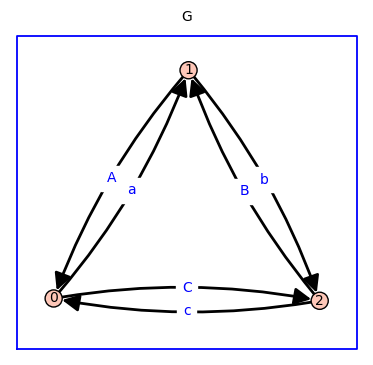


[-C - a      a      C]
[     A -b - A      b]
[     c      B -B - c]

For root/cycle [0] : A*B + b*c + A*c 

For root/cycle [1] : C*B + a*B + a*c 

For root/cycle [2] : C*b + a*b + C*A 

G cycles p: [(0, 1, 2, 0)] 

G cycles m: [(0, 2, 1, 0)] 

G cycles 2: [(0, 1, 0), (0, 2, 0), (1, 2, 1)] 


G cycle flux 0 : a * b * c

G cycle flux 1 : C * A * B

G cycle flux 2 : a * A * (B + c)

G cycle flux 3 : C * (b + A) * c

G cycle flux 4 : (C + a) * b * B



In [24]:
nvG, neG, betaG, Tg, TG, cycleG_p, cycleG_m, cycleG_2, cycleG, Jg, dict_vG, inverted_dict_vG, d_cycleG, inverted_d_cycleG =  cycle_flux_analysis(G,str='G')

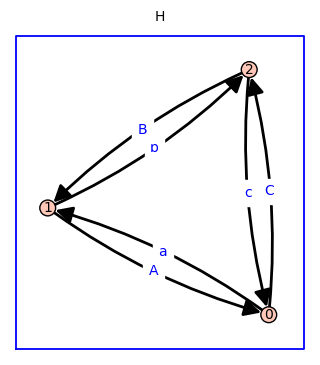


[-C - a      a      C]
[     A -b - A      b]
[     c      B -B - c]

For root/cycle [0] : A*B + b*c + A*c 

For root/cycle [1] : C*B + a*B + a*c 

For root/cycle [2] : C*b + a*b + C*A 

H cycles p: [(0, 1, 2, 0)] 

H cycles m: [(0, 2, 1, 0)] 

H cycles 2: [(0, 1, 0), (0, 2, 0), (1, 2, 1)] 


H cycle flux 0 : a * b * c

H cycle flux 1 : C * A * B

H cycle flux 2 : a * A * (B + c)

H cycle flux 3 : C * (b + A) * c

H cycle flux 4 : (C + a) * b * B



In [25]:

dH_c5 = {0: {1: 'v', 2: 'x', 4: 'Z'}, 1: {0: 'V', 2: 'w'}, 2: {1: 'W', 3: 'x'}, 3: {2: 'X', 4: 'y'}, 4: {0: 'z', 3: 'Y'}}
dH_c3 = {0: {1: 'x', 2: 'Z'}, 1: {0: 'X', 2: 'y'}, 2: {0: 'z', 1: 'Y'}}
dH_p4 = {0: {1: 'x'}, 1: {0: 'X', 2: 'y'}, 2: {1: 'Y', 3: 'z'}, 3: {2: 'Z'}}
dH_p3 = {0: {1: 'x'}, 1: {0: 'X', 2: 'y'}, 2: {1: 'Y'}}
dH_p2 = {0: {1: 'x'}, 1: {0: 'X'}}

dH_p2_r2 = {2: {3: 'x'}, 3: {2: 'X'}}
dH_c3_r3 = {3: {4: 'x', 5: 'Z'}, 4: {3: 'X', 5: 'y'}, 5: {3: 'z', 4: 'Y'}}
dH_p3_r3 = {3: {4: 'x'}, 4: {3: 'X', 5: 'y'}, 5: {4: 'Y'}}

dH = copy(dG);
#dH = dH_p2_r2

H, Vh = graph_and_edge_ring_from_dict(dH)
#Vh.inject_variables()
nvH, neH, betaH, Th, TH, cycleH_p, cycleH_m, cycleH_2, cycleH, Jh, dict_vH, inverted_dict_vH, d_cycleH, inverted_d_cycleH =  cycle_flux_analysis(H,str='H')

Multivariate Polynomial Ring in b, B, a, c, C, A over Integer Ring


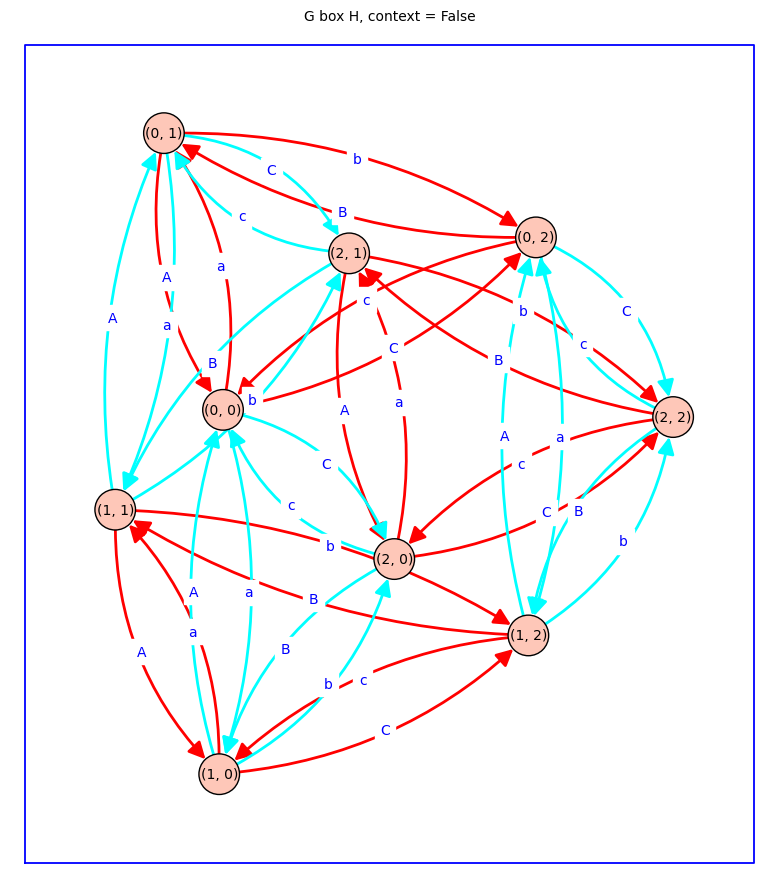

Multivariate Polynomial Ring in b1, c1, c2, B2, B0, C2, B1, a0, a1, a2, C1, A0, b0, A2, A1, b2, c0, C0 over Integer Ring


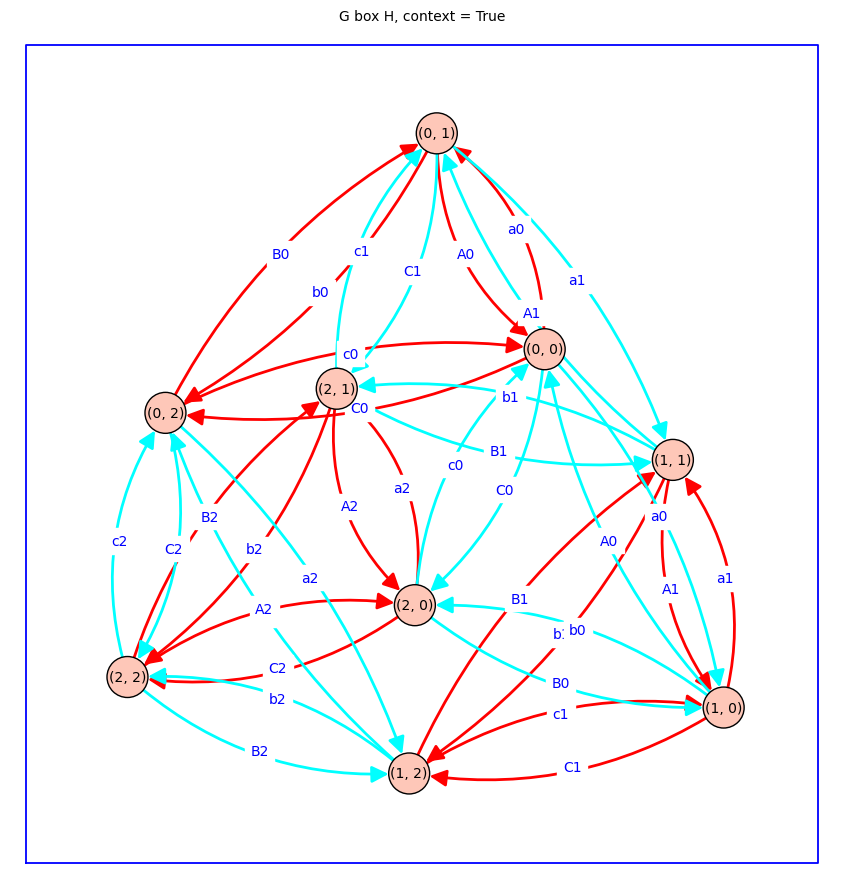

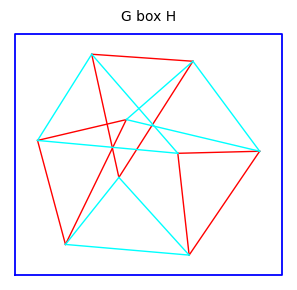

In [26]:
for context in [ False, True ]:
    GH = Cartesian_product(G, H, context=context)
    print(edge_ring_from_graph(GH))
    GH.show(edge_labels=True,figsize=12,graph_border=True,\
           edge_colors=cartesian_edge_color(GH,verbose=False),\
            title='G box H, context = ' + str(context))

GH0 = GH.to_undirected()
GH0.show(edge_labels=False,vertex_labels=False,vertex_size=0,figsize=4,graph_border=True,edge_colors=cartesian_edge_color(GH0,verbose=False),title='G box H')


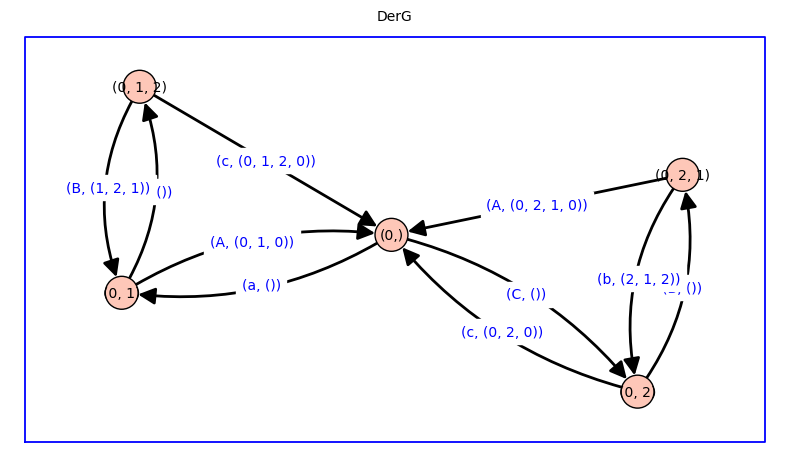

In [27]:
DerG = derived_graph(G)
DerG.show(edge_labels=True,figsize=8,graph_border=True,title='DerG')

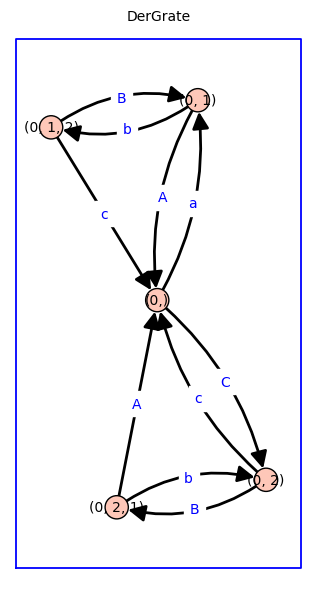

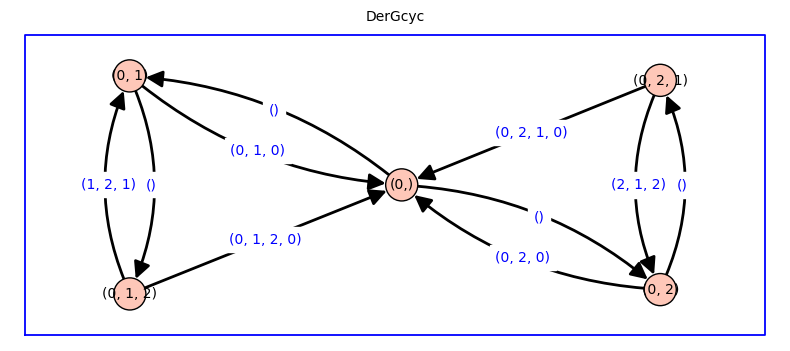

In [28]:
DerGrate, DerGcyc = split_derived_graph(DerG)
DerGrate.show(edge_labels=True,figsize=8,graph_border=True,title='DerGrate')
DerGcyc.show(edge_labels=True,figsize=8,graph_border=True,title='DerGcyc')

In [29]:
dict_Jg = cycle_fluxes_from_derived_graph(DerG,verbose=True)

rooted spanning tree of derived graph T(0,0) = (A*B + b*c + A*c) * (A*B + C*B + a*B + b*c + A*c + a*c + C*b + a*b + C*A) 

J (0, 1, 0) = a * A * (B + c) * (A*B + b*c + A*c) 

J (0, 1, 2, 0) = a * b * c * (A*B + b*c + A*c) 

J (1, 2, 1) = a * b * B * (A*B + b*c + A*c) 

J (0, 2, 0) = C * (b + A) * c * (A*B + b*c + A*c) 

J (0, 2, 1, 0) = C * A * B * (A*B + b*c + A*c) 

J (2, 1, 2) = C * b * B * (A*B + b*c + A*c) 



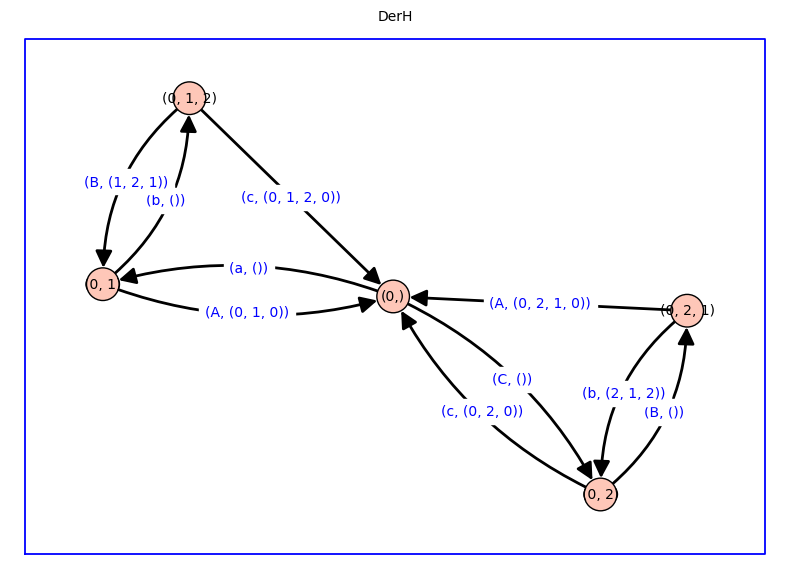

In [30]:
DerH = derived_graph(H)
DerH.show(edge_labels=True,figsize=8,graph_border=True,title='DerH')
DerHrate, DerHcyc = split_derived_graph(DerH)

In [31]:
dict_Jh = cycle_fluxes_from_derived_graph(DerH,verbose=True)

rooted spanning tree of derived graph T(0,0) = (A*B + b*c + A*c) * (A*B + C*B + a*B + b*c + A*c + a*c + C*b + a*b + C*A) 

J (0, 1, 0) = a * A * (B + c) * (A*B + b*c + A*c) 

J (0, 1, 2, 0) = a * b * c * (A*B + b*c + A*c) 

J (1, 2, 1) = a * b * B * (A*B + b*c + A*c) 

J (0, 2, 0) = C * (b + A) * c * (A*B + b*c + A*c) 

J (0, 2, 1, 0) = C * A * B * (A*B + b*c + A*c) 

J (2, 1, 2) = C * b * B * (A*B + b*c + A*c) 



***
*** context = False   reduce = False
***
Multivariate Polynomial Ring in b, B, a, c, C, A over Integer Ring


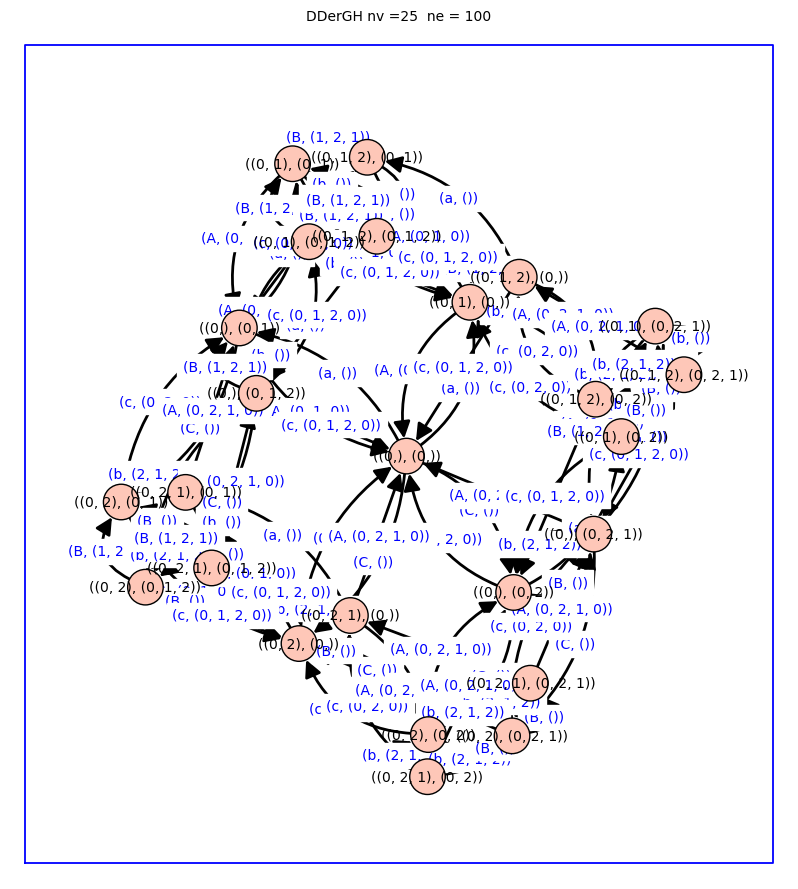

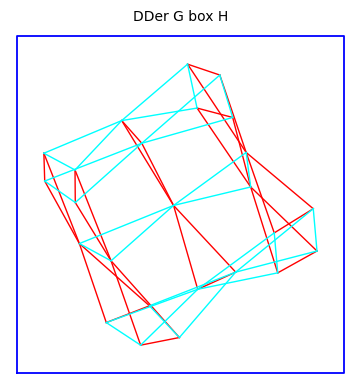

***
*** context = False   reduce = True
***
Multivariate Polynomial Ring in b, B, a, c, C, A over Integer Ring


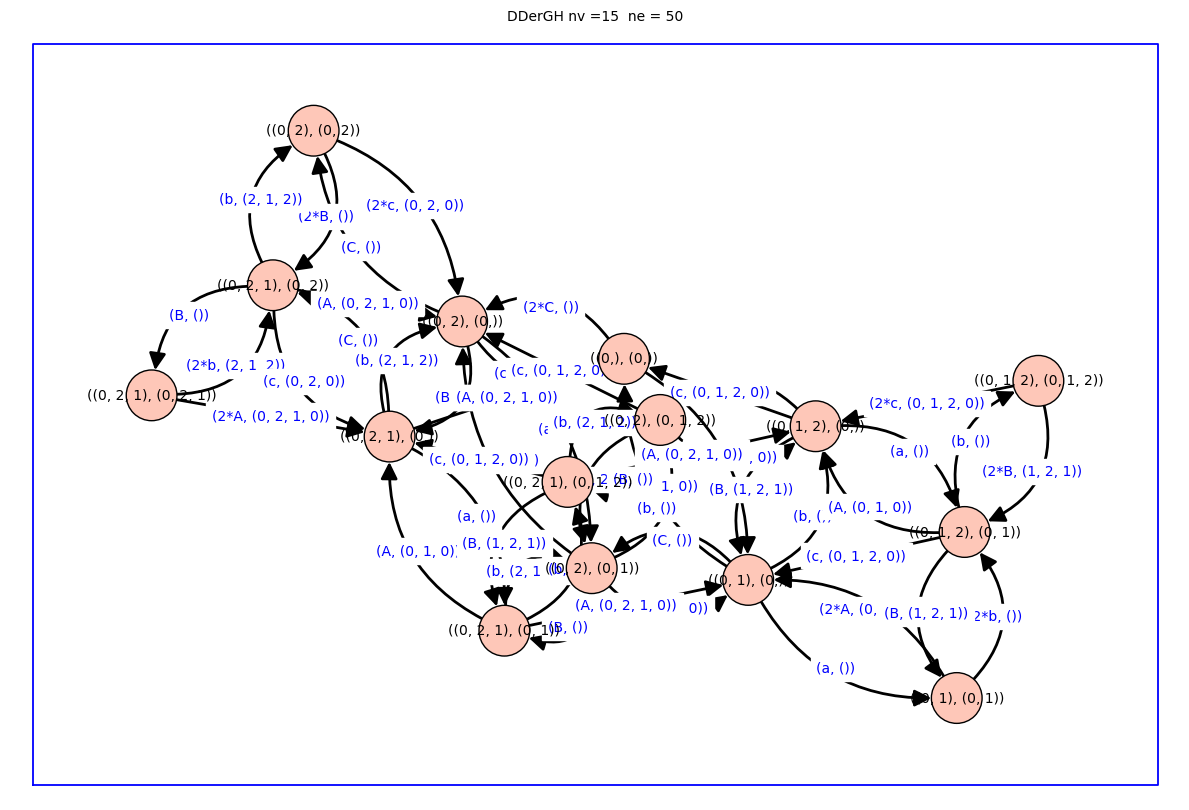

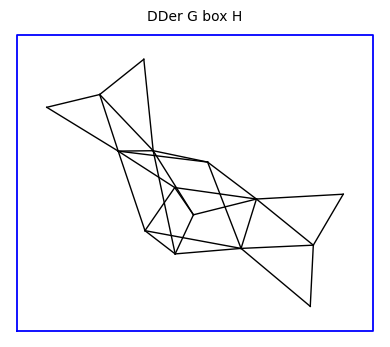

***
*** context = True   reduce = False
***
Multivariate Polynomial Ring in b1, c1, c2, B2, B0, C2, B1, a0, a1, a2, C1, A0, b0, A2, A1, b2, c0, C0 over Integer Ring


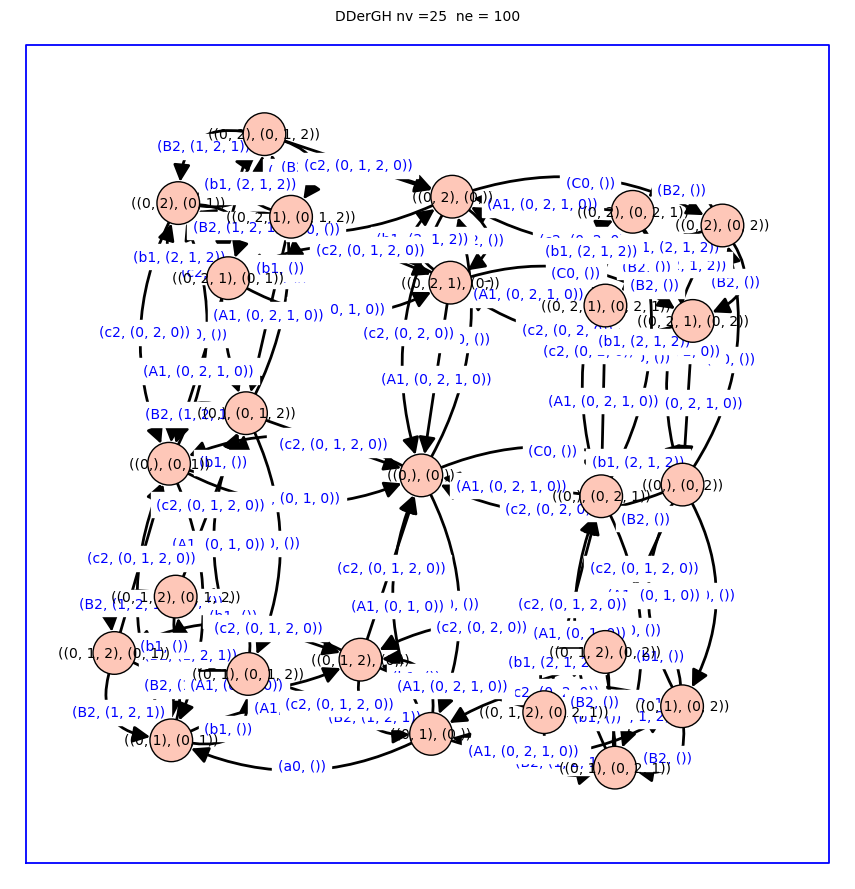

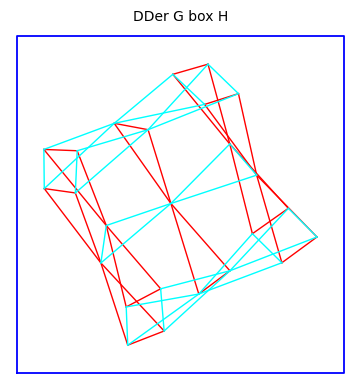

***
*** context = True   reduce = True
***
Multivariate Polynomial Ring in b1, c1, c2, B2, B0, C2, B1, a0, a1, a2, C1, A0, b0, A2, A1, b2, c0, C0 over Integer Ring


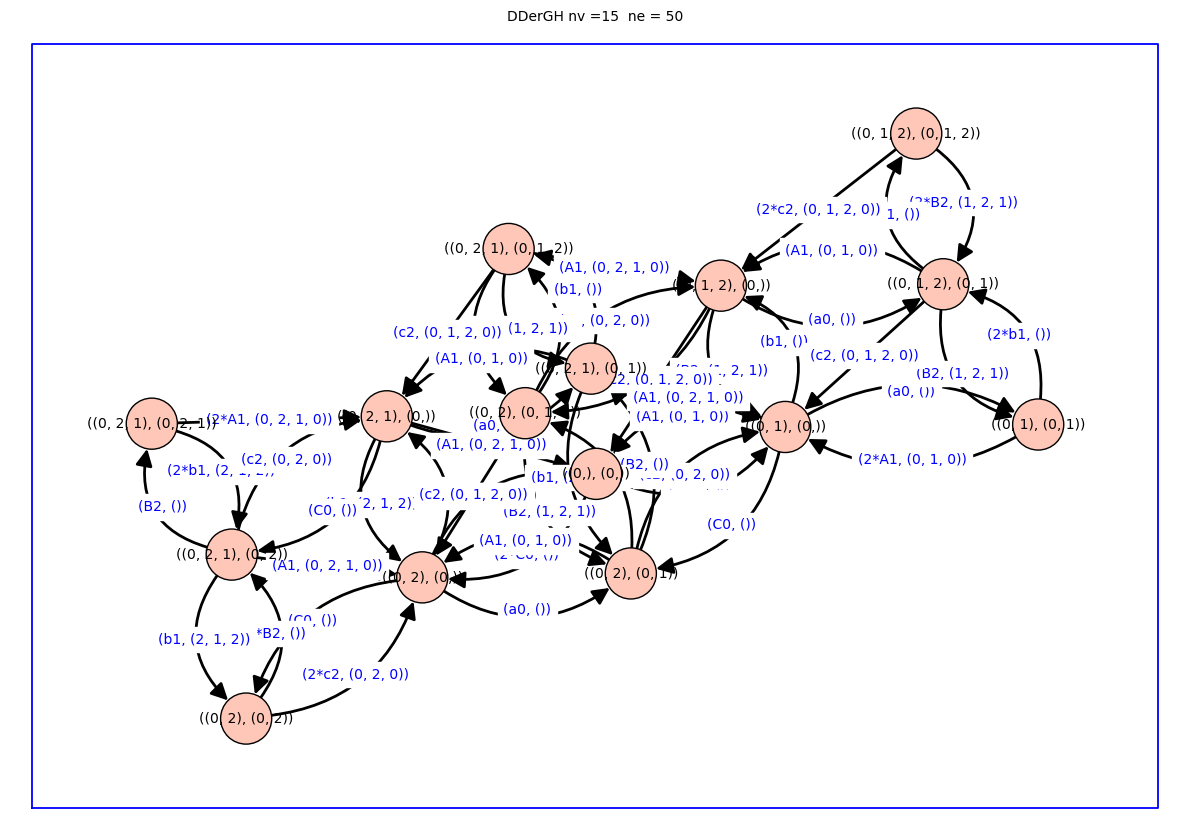

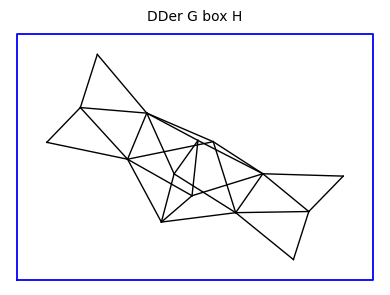

In [32]:
for context in [ False, True]:
    for reduce in [ False, True]:
        print('***')
        print('*** context =', str(context), '  reduce =', str(reduce))
        print('***')
        DDerGH = double_derived_graph(DerG,DerH,context=context,reduce=reduce)
        print(edge_ring_from_derived_graph(DDerGH))
        DDerGH.show(edge_labels=True,figsize=12,graph_border=True,\
                title='DDerGH '+'nv ='+str(DDerGH.order())+'  ne = '+str(DDerGH.size()))
        DDerGH0 = DDerGH.to_undirected()
        if reduce==False:
            edge_colors=cartesian_edge_color(DDerGH0,verbose=False)
        else:
            edge_colors=None
        DDerGH0.show(edge_colors=edge_colors,vertex_size=0,\
                     vertex_labels=False,graph_border=True,title='DDer G box H')

In [33]:
DDerGH = double_derived_graph(DerG,DerH,context=False,reduce=True)
dict_Jg_lumped_merge = cycle_fluxes_from_derived_graph(DDerGH,verbose=False,big=False)
for key in dict_Jg_lumped_merge:
    print(key,':',dict_Jg_lumped_merge[key],'\n')

(0, 1, 0) : 2^5 * A * a * (B + c) * (b + B + c + A) * (b + B + a + c + C + A) * (b*c + B*A + c*A)^2 * (b*a + B*a + b*c + a*c + b*C + B*C + B*A + c*A + C*A) * (2*b^3*a + 6*b^2*B*a + 6*b*B^2*a + 2*B^3*a + 2*b^2*a^2 + 4*b*B*a^2 + 2*B^2*a^2 + 4*b^3*c + 8*b^2*B*c + 4*b*B^2*c + 10*b^2*a*c + 16*b*B*a*c + 6*B^2*a*c + 5*b*a^2*c + 4*B*a^2*c + 8*b^2*c^2 + 8*b*B*c^2 + 10*b*a*c^2 + 6*B*a*c^2 + 2*a^2*c^2 + 4*b*c^3 + 2*a*c^3 + 2*b^3*C + 6*b^2*B*C + 6*b*B^2*C + 2*B^3*C + 4*b^2*a*C + 8*b*B*a*C + 4*B^2*a*C + 8*b^2*c*C + 12*b*B*c*C + 4*B^2*c*C + 7*b*a*c*C + 5*B*a*c*C + 6*b*c^2*C + 2*B*c^2*C + a*c^2*C + 2*b^2*C^2 + 4*b*B*C^2 + 2*B^2*C^2 + 2*b*c*C^2 + B*c*C^2 + 4*b^2*B*A + 8*b*B^2*A + 4*B^3*A + 4*b^2*a*A + 12*b*B*a*A + 8*B^2*a*A + b*a^2*A + 2*B*a^2*A + 12*b^2*c*A + 24*b*B*c*A + 12*B^2*c*A + 16*b*a*c*A + 16*B*a*c*A + 2*a^2*c*A + 16*b*c^2*A + 12*B*c^2*A + 8*a*c^2*A + 4*c^3*A + 6*b^2*C*A + 16*b*B*C*A + 10*B^2*C*A + 5*b*a*C*A + 7*B*a*C*A + 16*b*c*C*A + 16*B*c*C*A + 6*a*c*C*A + 6*c^2*C*A + 4*b*C^2*A + 5*B*C^2*A

In [34]:
DDerGH = double_derived_graph(DerG,DerH,context=True,reduce=True)
dict_Jg_lumped_merge = cycle_fluxes_from_derived_graph(DDerGH,verbose=False,big=False)
for key in dict_Jg_lumped_merge:
    print(key,':',dict_Jg_lumped_merge[key],'\n')

(0, 1, 0) : 2^5 * A1 * a0 * (c2 + B2) * (b1 + c2 + B2 + A1) * (b1 + c2 + B2 + a0 + A1 + C0) * (b1*c2 + c2*A1 + B2*A1)^2 * (b1*c2 + b1*a0 + c2*a0 + B2*a0 + c2*A1 + B2*A1 + b1*C0 + B2*C0 + A1*C0) * (4*b1^3*c2 + 8*b1^2*c2^2 + 4*b1*c2^3 + 8*b1^2*c2*B2 + 8*b1*c2^2*B2 + 4*b1*c2*B2^2 + 2*b1^3*a0 + 10*b1^2*c2*a0 + 10*b1*c2^2*a0 + 2*c2^3*a0 + 6*b1^2*B2*a0 + 16*b1*c2*B2*a0 + 6*c2^2*B2*a0 + 6*b1*B2^2*a0 + 6*c2*B2^2*a0 + 2*B2^3*a0 + 2*b1^2*a0^2 + 5*b1*c2*a0^2 + 2*c2^2*a0^2 + 4*b1*B2*a0^2 + 4*c2*B2*a0^2 + 2*B2^2*a0^2 + 12*b1^2*c2*A1 + 16*b1*c2^2*A1 + 4*c2^3*A1 + 4*b1^2*B2*A1 + 24*b1*c2*B2*A1 + 12*c2^2*B2*A1 + 8*b1*B2^2*A1 + 12*c2*B2^2*A1 + 4*B2^3*A1 + 4*b1^2*a0*A1 + 16*b1*c2*a0*A1 + 8*c2^2*a0*A1 + 12*b1*B2*a0*A1 + 16*c2*B2*a0*A1 + 8*B2^2*a0*A1 + b1*a0^2*A1 + 2*c2*a0^2*A1 + 2*B2*a0^2*A1 + 12*b1*c2*A1^2 + 8*c2^2*A1^2 + 8*b1*B2*A1^2 + 16*c2*B2*A1^2 + 8*B2^2*A1^2 + 2*b1*a0*A1^2 + 6*c2*a0*A1^2 + 6*B2*a0*A1^2 + 4*c2*A1^3 + 4*B2*A1^3 + 2*b1^3*C0 + 8*b1^2*c2*C0 + 6*b1*c2^2*C0 + 6*b1^2*B2*C0 + 12*b1*c2*B2*C